In [14]:
import math
import os

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
from scipy import ndimage

from utils.yolo import get_teeth_ROI
from utils.edge import integral_intensity_projection, vertical_line_drawing, get_rotation_angle
from utils.edge import get_slope, window_avg, get_valley_window, quick_get_roi
from scipy.signal import find_peaks
from dotenv import load_dotenv

from glob import glob
from pathlib import Path

matplotlib.use('module://matplotlib_inline.backend_inline')
%matplotlib inline

load_dotenv()



True

In [15]:
data_dir = '..' / Path(os.getenv('DATASET_DIR'))
model = torch.hub.load(r'..\YOLO', 'custom', path=r'..\YOLO\weights\8-bound.pt', source='local')


D:\Users\douli\anaconda3\envs\dentist-CV-main\lib\site-packages\yolov5\utils\plots.py:475: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyxy = torch.tensor(xyxy).view(-1, 4)


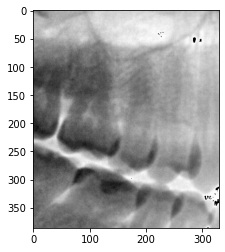

In [16]:
get_random = False
# get_random = True
if get_random:
    image_names = list(data_dir.glob('*.jpg'))
    random_image_index = np.random.randint(0, len(image_names))
    image_path = image_names[random_image_index]
    roi_index = np.random.randint(0, 7)
else:
    image_names = list(data_dir.glob('00008075.jpg'))
    image_path = image_names[0]
    roi_index = 0

filename = image_path.stem

im_g, flag, tooth_position = quick_get_roi(image_name=image_path, model=model, roi_index=roi_index)

plt.imshow(1 - im_g, cmap='gray')
plt.show()


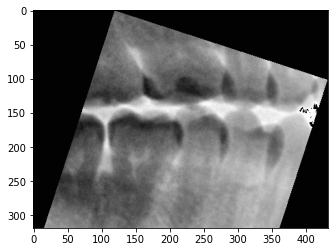

In [17]:
source = im_g

theta = get_rotation_angle(im_g, flag=flag, tooth_position=tooth_position)
source_rotated = ndimage.rotate(source, theta, reshape=True, cval=255)

margin = 30
padding = 150  # * abs(theta) // 10 + 1
if flag == 'upper':
    source_rotated = np.flip(source_rotated, axis=0)

source_rotated = source_rotated[:-padding, :]

plt.imshow(1 - source_rotated, cmap='gray')
plt.show()


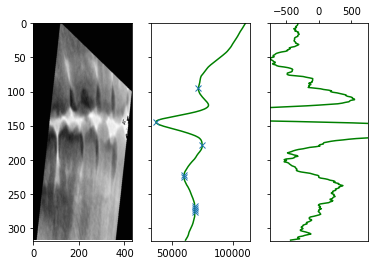

In [22]:
height, width = source_rotated.shape

hor, _ = integral_intensity_projection(source_rotated)
hor = window_avg(hor)
# Add slope degree test when acc too low.
hor_slope = get_slope(hor)

hor_valleys, _ = find_peaks(hor * -1)

# Plot area
index = np.array(range(height))
fig, axs = plt.subplots(1, 3, sharey='all')
# row i col 0
# image = vertical_line_drawing(image, *window_position, color=0)
axs[0].imshow(1 - source_rotated, aspect='auto', cmap='gray')
# for v in default_return[:2]:
#     axs[0].axhline(y=v, color='r')

# row i col 1
axs[1].plot(hor, index, 'g')
# axs[i][1].xaxis.tick_top()
axs[1].set_ylim(height, 0)
axs[1].plot(hor[hor_valleys], hor_valleys, "x")
# for v in np.where(np.logical_and(hor_slope > -20, hor_slope < 20))[0]:
#     axs[1].axhline(y=v, color='r')

# row i col 2
axs[2].plot(hor_slope, index, 'g')
axs[2].xaxis.tick_top()
axs[2].set_ylim(height, 0)
axs[2].set_xlim(-hor_slope.std(), hor_slope.std())
# for v in np.where(np.logical_and(hor_slope > -10, hor_slope < 10))[0]:
#     axs[2].axhline(y=v, color='r')

plt.show()



[ 95 145 179 223 226]


NameError: name 'window_position' is not defined

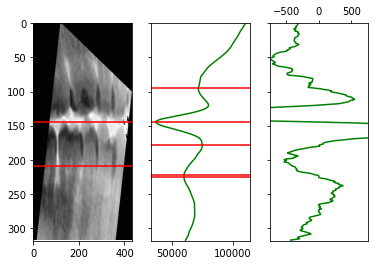

In [21]:
jaw_sep_line = 0
gum_sep_line = height
default_return = [gum_sep_line, jaw_sep_line, hor_valleys, hor]

hor_valleys = hor_valleys[hor_valleys < height - padding // 2]
if hor_valleys.size > 0:
    jaw_sep_line = hor_valleys[hor[hor_valleys].argmin()]

    gum_sep_line_pool = hor_valleys[hor_valleys > jaw_sep_line + 30]
    if gum_sep_line_pool.size == 0:
        gum_sep_line = jaw_sep_line + 100 + margin
    else:
        gum_sep_line = hor_valleys[hor_valleys > jaw_sep_line + 30][0]

    gum_sep_line += margin

    if jaw_sep_line < height // 2:
        default_return[0] = gum_sep_line
        default_return[1] = jaw_sep_line

# Plot
index = np.array(range(height))

# Plot area
fig, axs = plt.subplots(1, 3, sharey='all')
# row i col 0
# image = vertical_line_drawing(image, *window_position, color=0)
axs[0].imshow(1 - source_rotated, aspect='auto', cmap='gray')
for v in default_return[:2]:
    axs[0].axhline(y=v, color='r')

# row i col 1
axs[1].plot(hor, index, 'g')
# axs[i][1].xaxis.tick_top()
axs[1].set_ylim(height, 0)
for v in hor_valleys:
    axs[1].axhline(y=v, color='r')

# row i col 2
axs[2].plot(hor_slope, index, 'g')
axs[2].xaxis.tick_top()
axs[2].set_ylim(height, 0)
axs[2].set_xlim(-hor_slope.std(), hor_slope.std())

plt.show()

print(default_return[:2])


In [ ]:
# hor_valleys
# hor_valleys[hor[hor_valleys].argmin()]
default_return


In [ ]:
x = np.array(range(0, hor.shape[0]))

dy = np.gradient(hor)
dx = np.gradient(x)
d = np.gradient(hor, x)

# a = d[hor_valleys]

zero_points = np.where(abs(d) < 10)[0]

print(hor_valleys)
print(zero_points)

plt.plot(hor)
for i in zero_points:
    plt.axvline(x=i, color='r')
plt.show()

plt.plot(d)
for i in zero_points:
    plt.axvline(x=i, color='r')
plt.show()

plt.plot(hor_slope)
for i in hor_valleys:
    plt.axvline(x=i, color='r')
plt.show()
